<a href="https://colab.research.google.com/github/I-ULISES-I/Colabfiles/blob/main/ProyectoProgADAP_256056.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyecto de Programación para Analítica Descriptiva y Predictiva**
## Nombre del Proyecto: Análisis de la Resistencia a la Compresión del Concreto
## Grupo: B
## Autor: Ulises Hernández Rodríguez
## Matrícula: 256056
## Fecha: 21/May/25

# **1. Introducción**


## - Descripción del problema: ¿Qué queremos analizar o predecir?


El concreto es el material más importante en la ingeniería civil. Su resistencia a la compresión (strength) es una función altamente no lineal de la edad (age) y los componentes. Estos componentes incluyen cemento (cement), escoria de alto horno (slag), cenizas volantes (ash), agua (water), superplastificante (superplastic), grava (coarseagg) y arena (fineagg).

## - Objetivo del análisis: ¿Qué impacto tendrá este análisis?


El objetivo es tratar de predecir la resistencia a la compresión que tendrá el concreto, medida en megapascales (MPa), dada una serie de características que conforman su mezcla y su edad.

## - Fuente de datos: ¿De dónde provienen los datos?


La resistencia real a la compresión del concreto (MPa) para una mezcla dada a una edad específica (días) fue determinada en laboratorio.

# **2. Captura y Carga de Datos**

## - Explicación de la fuente de datos: ¿Cuáles son las fuentes de datos?, ¿Qué formato tienen los datos (CSV, SQL, API, etc.)?, ¿Cuántas observaciones y variables contiene el dataset?

El conjunto de datos fue extraídos de kaggle desde el siguiente enlace: https://www.kaggle.com/datasets/vinayakshanawad/cement-manufacturing-concrete-dataset, donde se puede descargar en formato CSV para su posterior uso.

Los datos están en formato bruto (sin escalar), constan de 8 variables de entrada númericas, 1 variable de salida númerica y 1030 casos (observaciones). En el siguiente apartado se presenta un primer vistazo del contenido del archivo, junto con las bibliotecas que fueron utilizadas para la realización del proyecto.

## - Explicación sobre problemas en la carga de Datos y el Código para la carga de datos desde archivos (bibiotecas, etc.)

In [2]:
#Importación de librerías.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats

#Carga de conjunto de datos.
df = pd.read_csv('drive/MyDrive/ClassFiles/concrete.csv')

#Impresión de información.
print("Información del archivo:")
print(df.info())
print("\nPrimeras 5 filas del archivo:")
print(df.head())

Información del archivo:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB
None

Primeras 5 filas del archivo:
   cement   slag    ash  water  superplastic  coarseagg  fineagg  age  \
0   141.3  212.0    0.0  203.5           0.0      971.8    748.5   28   
1   168.9   42.2  124.3  158.3          10.8     1080.8    796.2   14   
2   250.0    0.0   95.7  187.4           5.5      956.9    861.2   28   
3   266.0  114.0 

Como se puede observar con df.info(), se tienen 8 columnas de tipo float64 y 1 columna de tipo int64. Cada una de las características predictoras tiene como medida $kg/m^3$, a expeción de age, cuya medida está en días. La variable objetivo es strength, la cual está en megapascales (MPa).

No hubo problemas en cuanto a la carga del archivo, sin embargo, un problema que se presentó luego de haber estado trabajando durante todo el semestre fue con Google Colab. Por algún motivo, el drive donde se alojan los archivos dejó de cargarse correctamente, por lo que fue necesario otorgarle permisos adicionales a la aplicación para que pudiese funcionar.

#**3.Transformación y Preprocesamiento - Data Wrangling**

## - Identificación de Tipos de Datos

Este paso ya puede observarse más arriba con df.info(), pero es importante mencionar que también existe la función df.dtypes, cuya salida genera una lista de los nombres de la columnas junto con su respectivo tipo de dato.

In [3]:
#Impresión de tipos de datos.
print("Tipos de datos:")
print(df.dtypes)

Tipos de datos:
cement          float64
slag            float64
ash             float64
water           float64
superplastic    float64
coarseagg       float64
fineagg         float64
age               int64
strength        float64
dtype: object


## - Cantidad de Valores nulos

La información que acompaña al conjunto de datos desde el enlace no proporciona detalles sobre la cantidad de valores nulos o faltantes. Es por ello que se realiza la comprobación para asegurarse de que no haya tales casos que afecten el análisis en etapas más avanzadas.

In [4]:
#Impresión de valores nulos.
print("Valores nulos:")
print(df.isnull().sum())

Valores nulos:
cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64


##- Explicación sobre cada una de las problemáticas encontradas, las soluciones y el código

Adicionalmente, se hizó la comprobación de que no existieran datos duplicados, ya que estos pueden agregar ruido durante el proceso del análisis y alterar los resultados. Se encontró que, efectivamente, el conjunto de datos contenía registros repetidos, por lo cual se realizó un conteo para saber cuántos eran y proceder con su eliminación, ya que no aportan nada nuevo y solo las estadísticas descriptivas.

In [5]:
#Impresión de datos duplicados.
print("Cantidad de datos duplicados:", df.duplicated(keep='first').sum())

#Impresión de registros duplicados.
print("\nRegistros duplicados:")
print(df[df.duplicated(keep=False)].sort_values(by='cement'))

#Eliminación de registros duplicados.
df.drop_duplicates(keep='first', inplace=True)

#Impresión de datos duplicados.
print("\nCantidad de datos duplicados:", df.duplicated(keep='first').sum())

Cantidad de datos duplicados: 25

Registros duplicados:
     cement   slag  ash  water  superplastic  coarseagg  fineagg  age  \
468   252.0    0.0  0.0  185.0           0.0     1111.0    784.0   28   
333   252.0    0.0  0.0  185.0           0.0     1111.0    784.0   28   
91    362.6  189.0  0.0  164.9          11.6      944.7    755.8    7   
88    362.6  189.0  0.0  164.9          11.6      944.7    755.8    3   
245   362.6  189.0  0.0  164.9          11.6      944.7    755.8   91   
420   362.6  189.0  0.0  164.9          11.6      944.7    755.8    3   
190   362.6  189.0  0.0  164.9          11.6      944.7    755.8   56   
96    362.6  189.0  0.0  164.9          11.6      944.7    755.8   28   
463   362.6  189.0  0.0  164.9          11.6      944.7    755.8   56   
400   362.6  189.0  0.0  164.9          11.6      944.7    755.8    3   
738   362.6  189.0  0.0  164.9          11.6      944.7    755.8   28   
766   362.6  189.0  0.0  164.9          11.6      944.7    755.8   9

Es importante mencionar que al momento de enlistar los registros duplicados se hace con el parámetro keep=False, esto con el objetivo de visualizar que y cuántos registros había en el dataset. Al realizar la eliminación, se hace con keep='first', manteniendo el primer registro que aparezca y borrando los siguientes.

In [6]:
# Seleccionar solo las columnas numéricas
columnas_numericas = df.select_dtypes(include='number').columns

# Eliminar outliers de cada columna usando IQR
for col in columnas_numericas:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    df = df[(df[col] >= limite_inferior) & (df[col] <= limite_superior)]


# **4. Análisis Descriptivo de Datos**

## - Preguntas a responder con el AD



*   ¿Cuál es la tendencia central (media, mediana, moda) de cada variable?

*   ¿Cuál es la dispersión o variabilidad de los datos (rango, desviación estándar, IQR)?

*   ¿Cuáles son los rangos y comportamientos generales de las variables más importantes?



## - Explicación de Estadísticas Básicas Aplicadas, Visualización de Datos con Gráficos, y Resumen de las respuestas

El siguiente bloque de código presenta las estadísticas descriptivas que en primera instancia permiten tener una idea temprana de la forma que tienen los datos.

In [7]:
#Impresión de estadísticas descriptivas.
print("Estadísticas descriptivas:")
print(df.describe())

#Impresión de modas.
print("\nModas:")
print(df.mode().iloc[0])

Estadísticas descriptivas:
           cement        slag         ash       water  superplastic  \
count  911.000000  911.000000  911.000000  911.000000    911.000000   
mean   272.269594   71.440066   59.930626  181.301098      6.022942   
std    101.408479   86.144700   64.534179   18.586211      5.235400   
min    102.000000    0.000000    0.000000  127.300000      0.000000   
25%    190.300000    0.000000    0.000000  167.000000      0.000000   
50%    252.300000   19.000000    0.000000  185.000000      6.700000   
75%    335.000000  142.650000  119.900000  192.000000     10.000000   
max    540.000000  342.100000  200.100000  228.000000     22.100000   

         coarseagg     fineagg         age    strength  
count   911.000000  911.000000  911.000000  911.000000  
mean    976.479363  775.702195   32.119649   34.033019  
std      77.576583   75.336470   28.420546   15.852205  
min     801.000000  594.000000    1.000000    2.330000  
25%     932.000000  736.800000    7.000000   22.

¿Qué se puede concluir? Bueno, de primera vista es posible inferir que hay presencia de outliers en columnas como slag, water, superplastic, fineagg, age y strength. Esto es posible si se observa con detenimiento el valor de la desviación estándar y se compara con los cuartiles que se presentan para las variables. También, con el mismo procedimiento anterior, se puede concluir que algunas variables tendrán distribuciones sesgadas a la derecha.

Otro de los puntos a recalcar es, si se observa la moda, hay mucha presencia de ceros en columnas como slag, ash y superplastic. Esto no necesariamente indica que tales registros fueron capturados erróneamente, sino que pueden representar mezclas de concreto a las cuales no se les añadieron dichos elementos. Sin embargo, para la etapa donde se tenga que hacer uso de transofrmaciones para intentar obtener distribuciones normales en las variables, puede que exista algún tipo de conflicto con los métodos.

En la siguiente sección se presentan los gráficos correspondientes para poder visualizar de forma más clara dichas observaciones.

# **5. Análisis Exploratorio de los Datos**

## - Preguntas a responder



*   ¿Cómo se distribuyen los datos de cada variable?

*   ¿Existen valores atípicos (outliers) que podrían afectar el análisis?

*   ¿Hay correlaciones entre las variables predictoras y la variable objetivo?

*   ¿Las variables siguen una distribución normal o presentan sesgo?



## - Estadísticas Empleadas, visualización y Resumen de las respuestas encontradas.

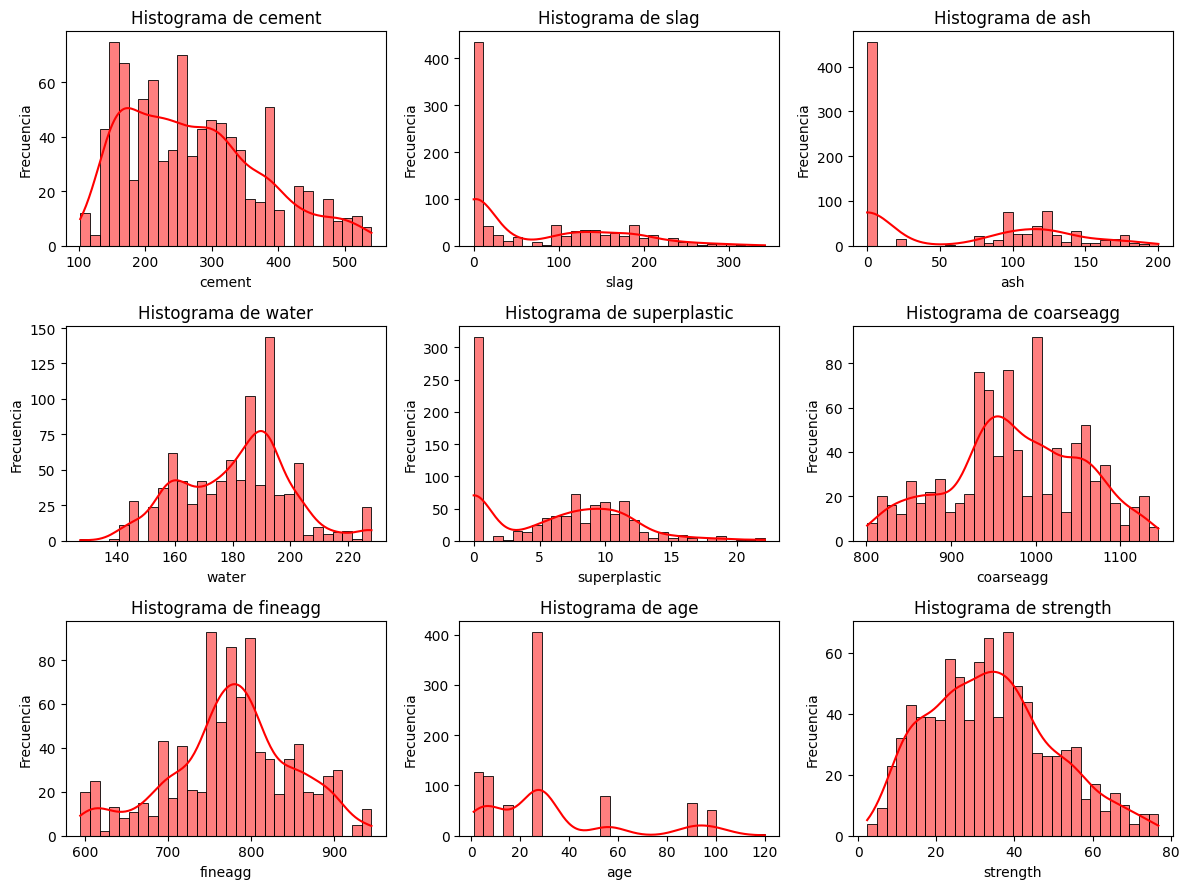

In [8]:
#Creación y diseño de histogramas.
plt.figure(figsize=(12, 9))
for i, columna in enumerate(df, 1):
  plt.subplot(3, 3, i)
  sns.histplot(df[columna], kde=True, bins=30, color='red')
  plt.title(f"Histograma de {columna}")
  plt.xlabel(columna)
  plt.ylabel("Frecuencia")

#Impresión de histogramas.
plt.tight_layout()
plt.show()

En base a los histogramas anteriores y como se había mencionado previamente, variables como slag, ash, superplastic y age presentan distribuciones sesgadas a la derecha. Se debe aplicar alguna técnica de transformación para intentar acercarlas a una distribución normal.

Variables como cement, water, coarseagg y fineagg presentan distribuciones medianamente cercanas a la distribución normal, pero siguen manteniendo picos extraños que alteran su forma en general. También es posible aplicar una técnica de transformación y ver resultados.

Por otro lado (y como buena noticia), la variable objetivo es cercana a una distribución normal, por lo que se considera omitir aplicarle una transformación ya que no le beneficiaría mucho, incluso pudiera ser contraproducente.

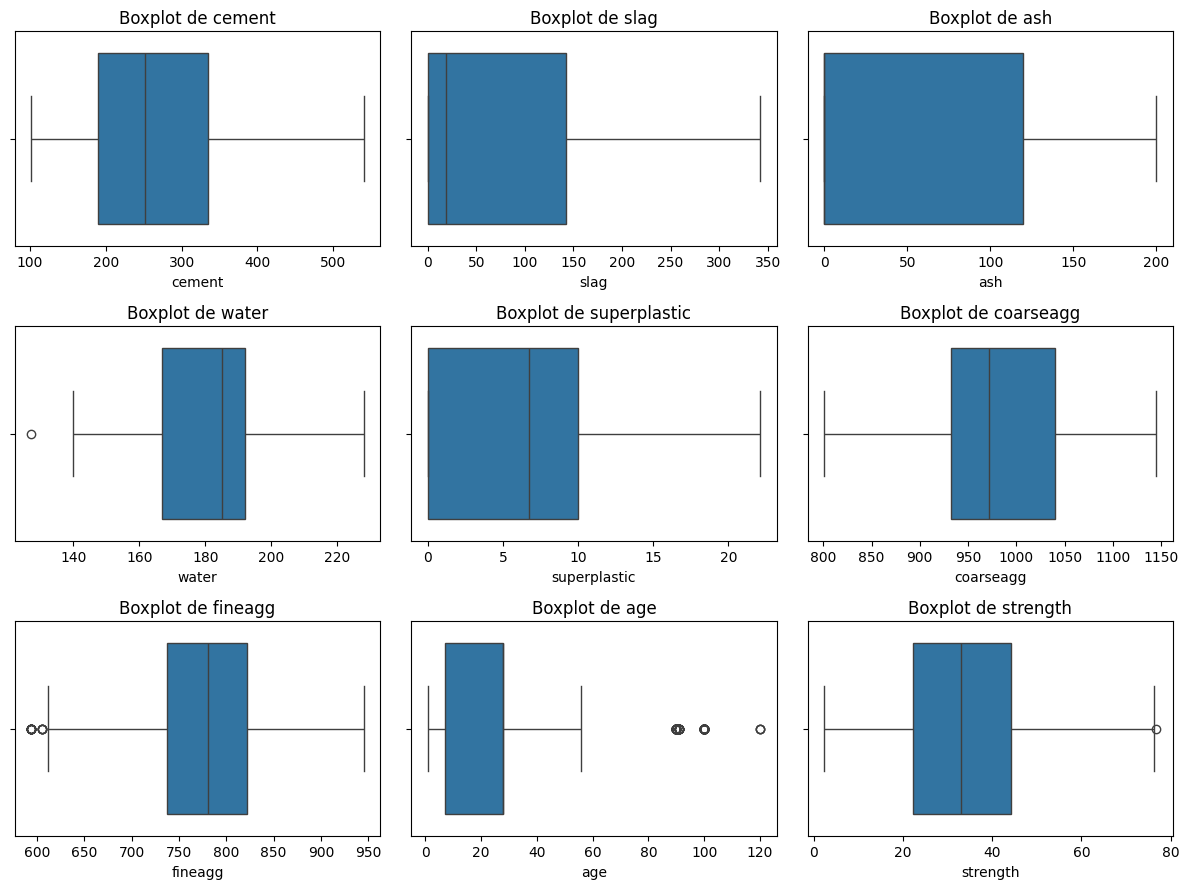

In [9]:
#Creación y diseño de boxplots.
plt.figure(figsize=(12, 9))
for i, columna in enumerate(df, 1):
  plt.subplot(3, 3, i)
  sns.boxplot(x=df[columna])
  plt.title(f"Boxplot de {columna}")

#Impresión de boxplots.
plt.tight_layout()
plt.show()

En base a los boxplots, hay presencia de outliers en variables como slag, water, superplastic, fineagg, age y strength. Considerar eliminarlos podría resultar beneficioso para tales variables, centralizando las métricas, sobretodo para la variable age. Sin embargo, para el objetivo de este análisis se planteó conservar tales outliers ya que estos pueden representar casos excepcionales que pueden ayudar en la generalización de modelos, es decir, entrenar modelos que sean capaces de abordar una situación realista. Muchas de las veces estos serán los conjuntos de datos que se en encontrarán en la vida real, sin patrónes, sin ajustes ficticios, por lo que es importante aprender a lidiar con ellos y ver el impacto que tienen.

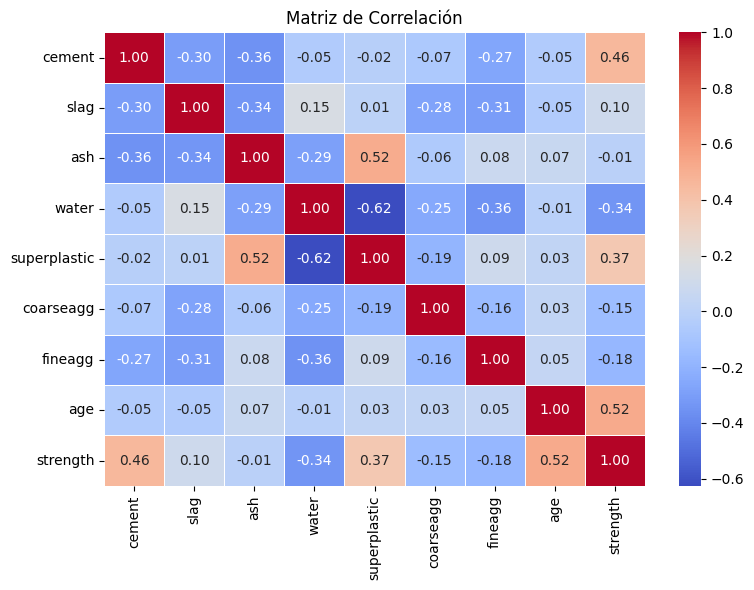

In [10]:
#Cálculo de matriz de correlación.
matriz_correlacion = df.corr()

#Creación y diseño de mapa de calor.
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Matriz de Correlación")

#Impresión de mapa de calor.
plt.tight_layout()
plt.show()

Si se observa la matriz de correlación, se pueden observar correlaciones interesantes. Las más destacables son las que están relacionadas con la variable objetivo (strength). Strength tiene una correlación medianamente positiva con cement, superplastic y age, mientras que también presenta correlaciones levemente negativas con water, coarseagg, y fineagg. Aplicado a un caso de la vida real, estás correlaciones tienen sentido ya que pueden hacer que la mezcla del concreto se vuelva más viscosa, dificultando su capacidad para solidificarse. Mientras que sus correlaciones positivas fortalecen su resistencia.

También existen correlaciones entre otras variables, por mencionar algunas: levemente negativas de cement con slag, ash y fineagg; slag con cement, ash, coarseagg y fineagg; levemente positivas de ash con superplastic; water con slag y age; entre muchas otras más. Para profundizar más en dichas correlaciones, observese con detenimiento la matriz de correlación

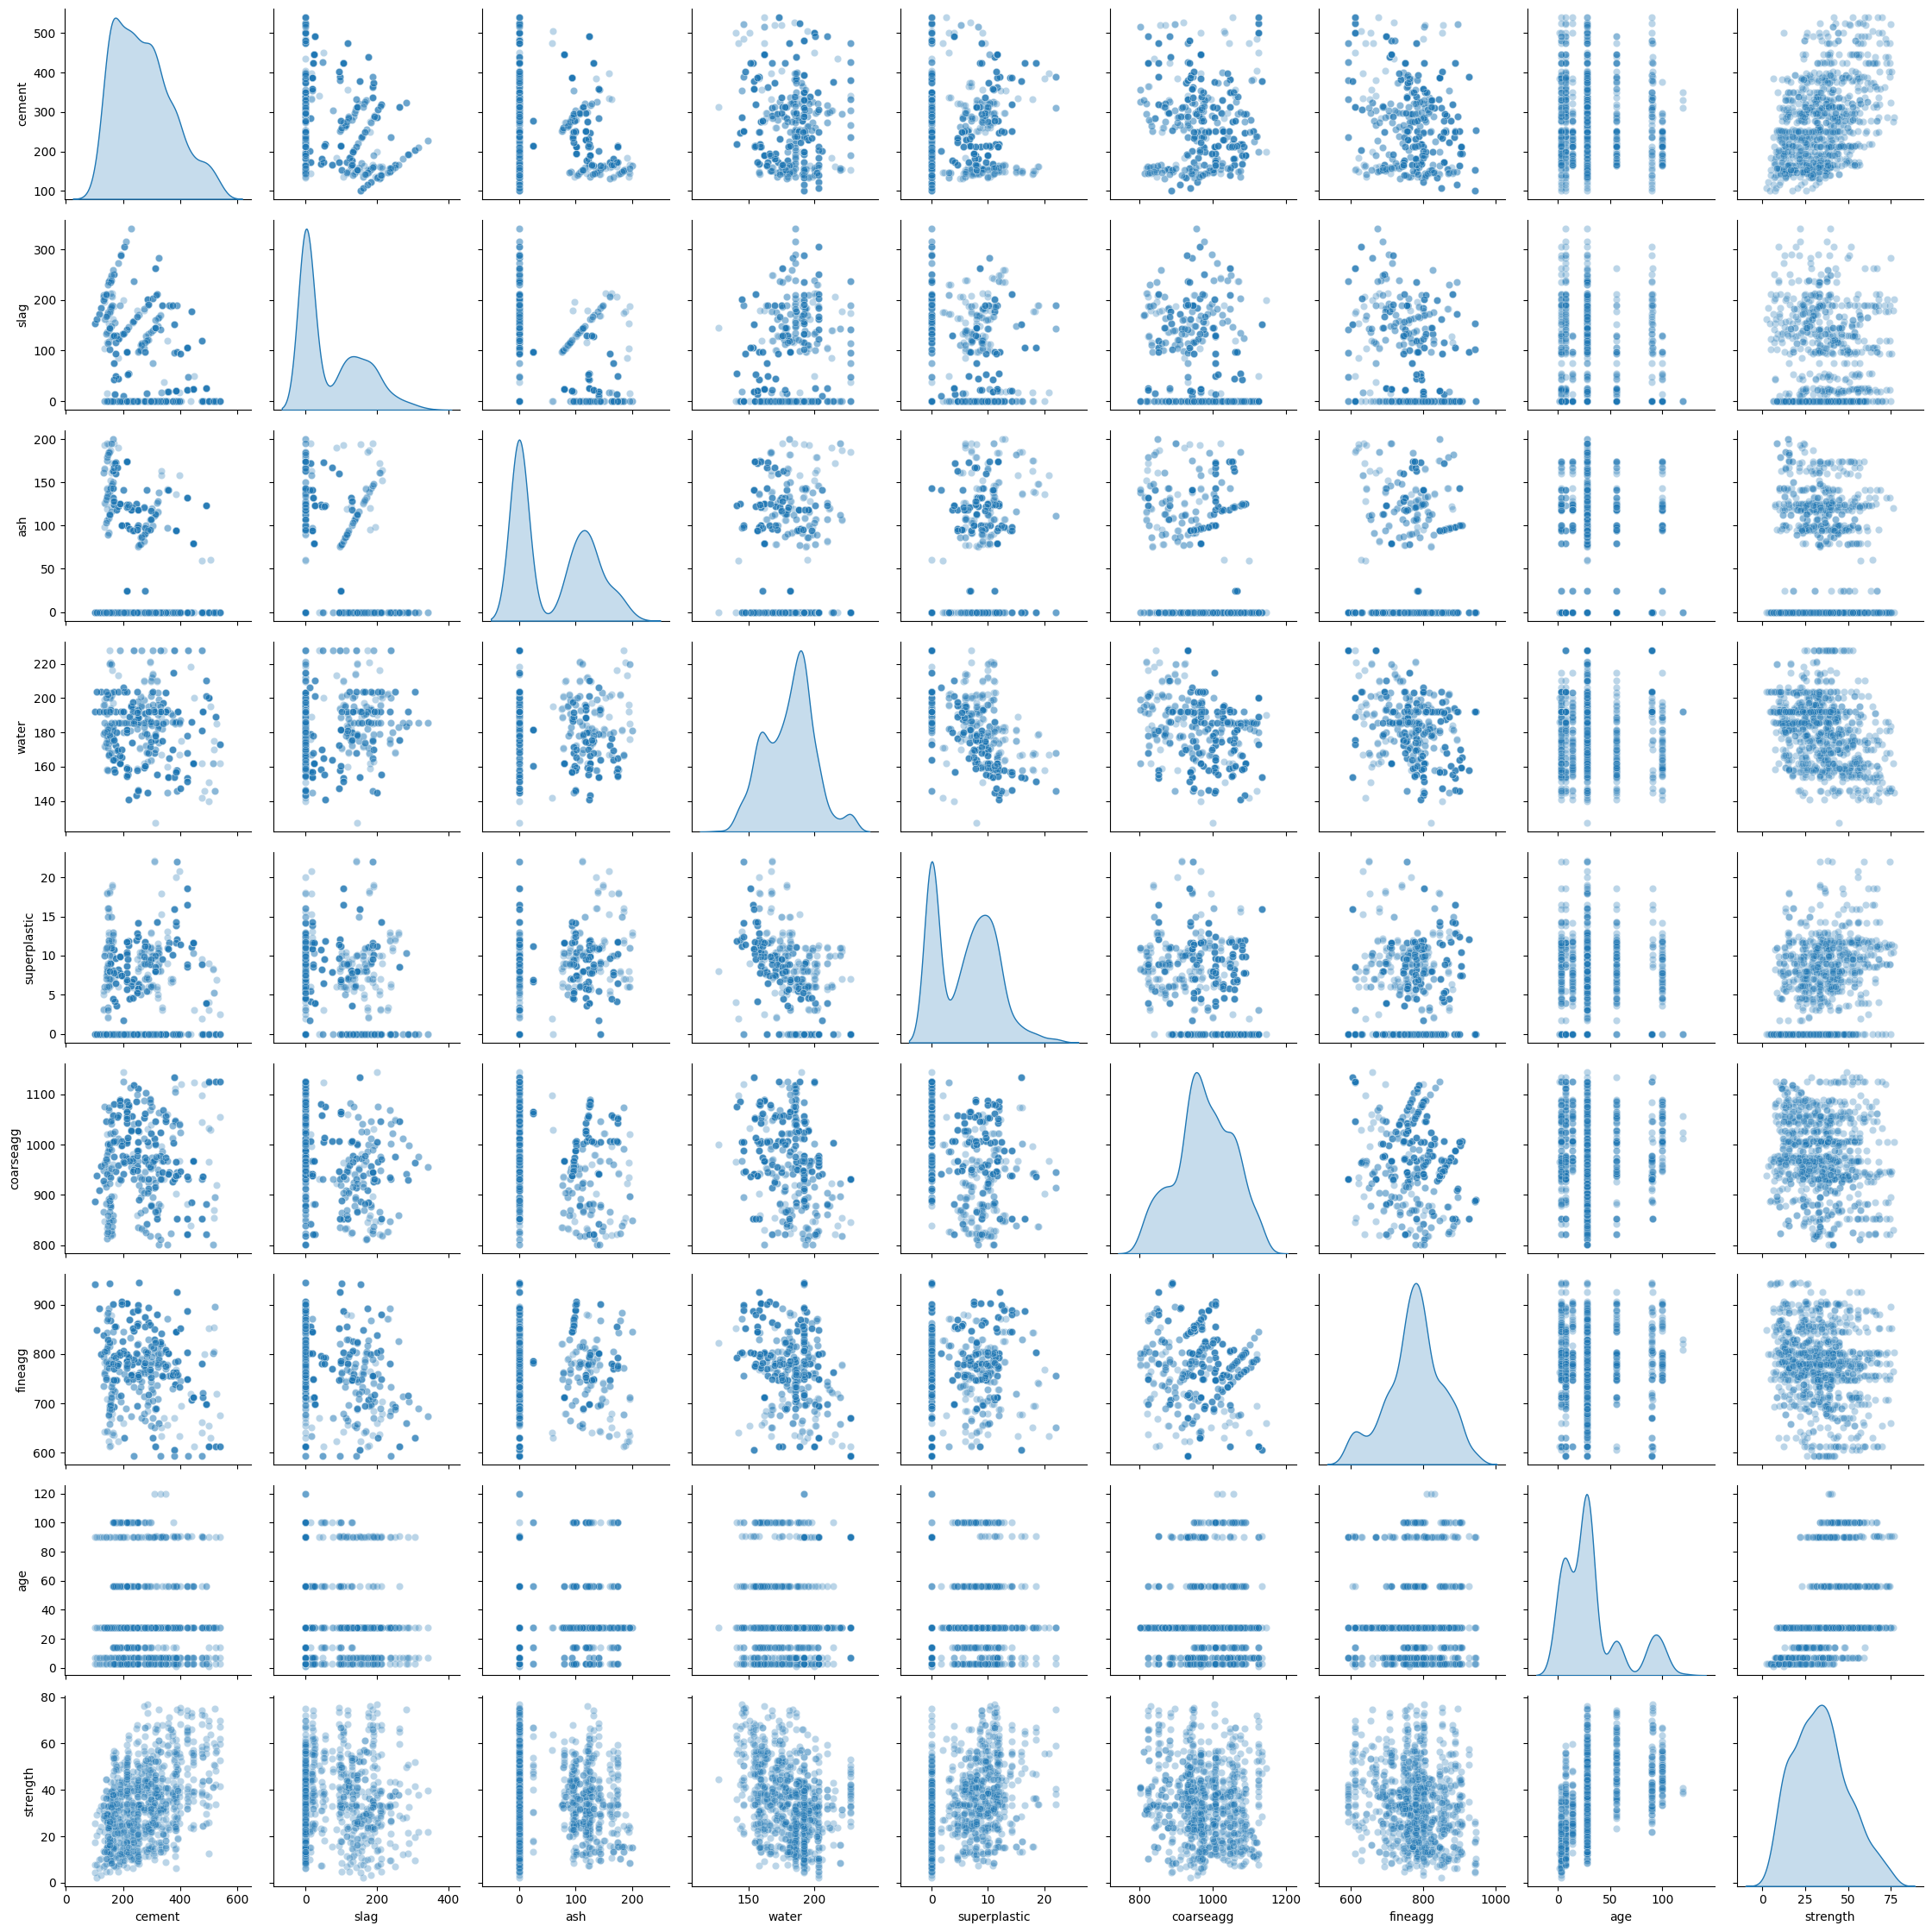

In [11]:
#Creación y diseño de pairplot.
sns.pairplot(df, plot_kws={'alpha': 0.3}, diag_kind='kde')

#Impresión de pairplot.
plt.tight_layout()
plt.show()

Este pairplot tuvo como finalidad intentar encontrar relaciónes lineales con la variable objetivo (strength). Desafortunadamente, no se alcanza a percibir con tal claridad dichas relaciones por que hay mucha distribución aleatoria con las variables predictoras. Posiblemente se puede encontrar alguna relación levemente lineal ascendente con cement, e inclusive con age, pero ésta última tiene bastante dispersión.

# **6. Análisis Predictivo**


## - Preprocesamiento para Análisis Predictivo: Problemas, Técnicas y Código


El primer problema a resolver fue intentar hacer que las variables predictoras tuvieran una distribución normal antes de proceder con el modelado, así que se aplicaron 3 técnicas de transformación que se adecuaban a los datos. También se presenta una serie de histogramas que compara las distribuciones obtenidas luego de aplicar las transformaciones seleccionadas, esto con la finalidad de escoger la transformación que mas obtuviera distribuciones normales.

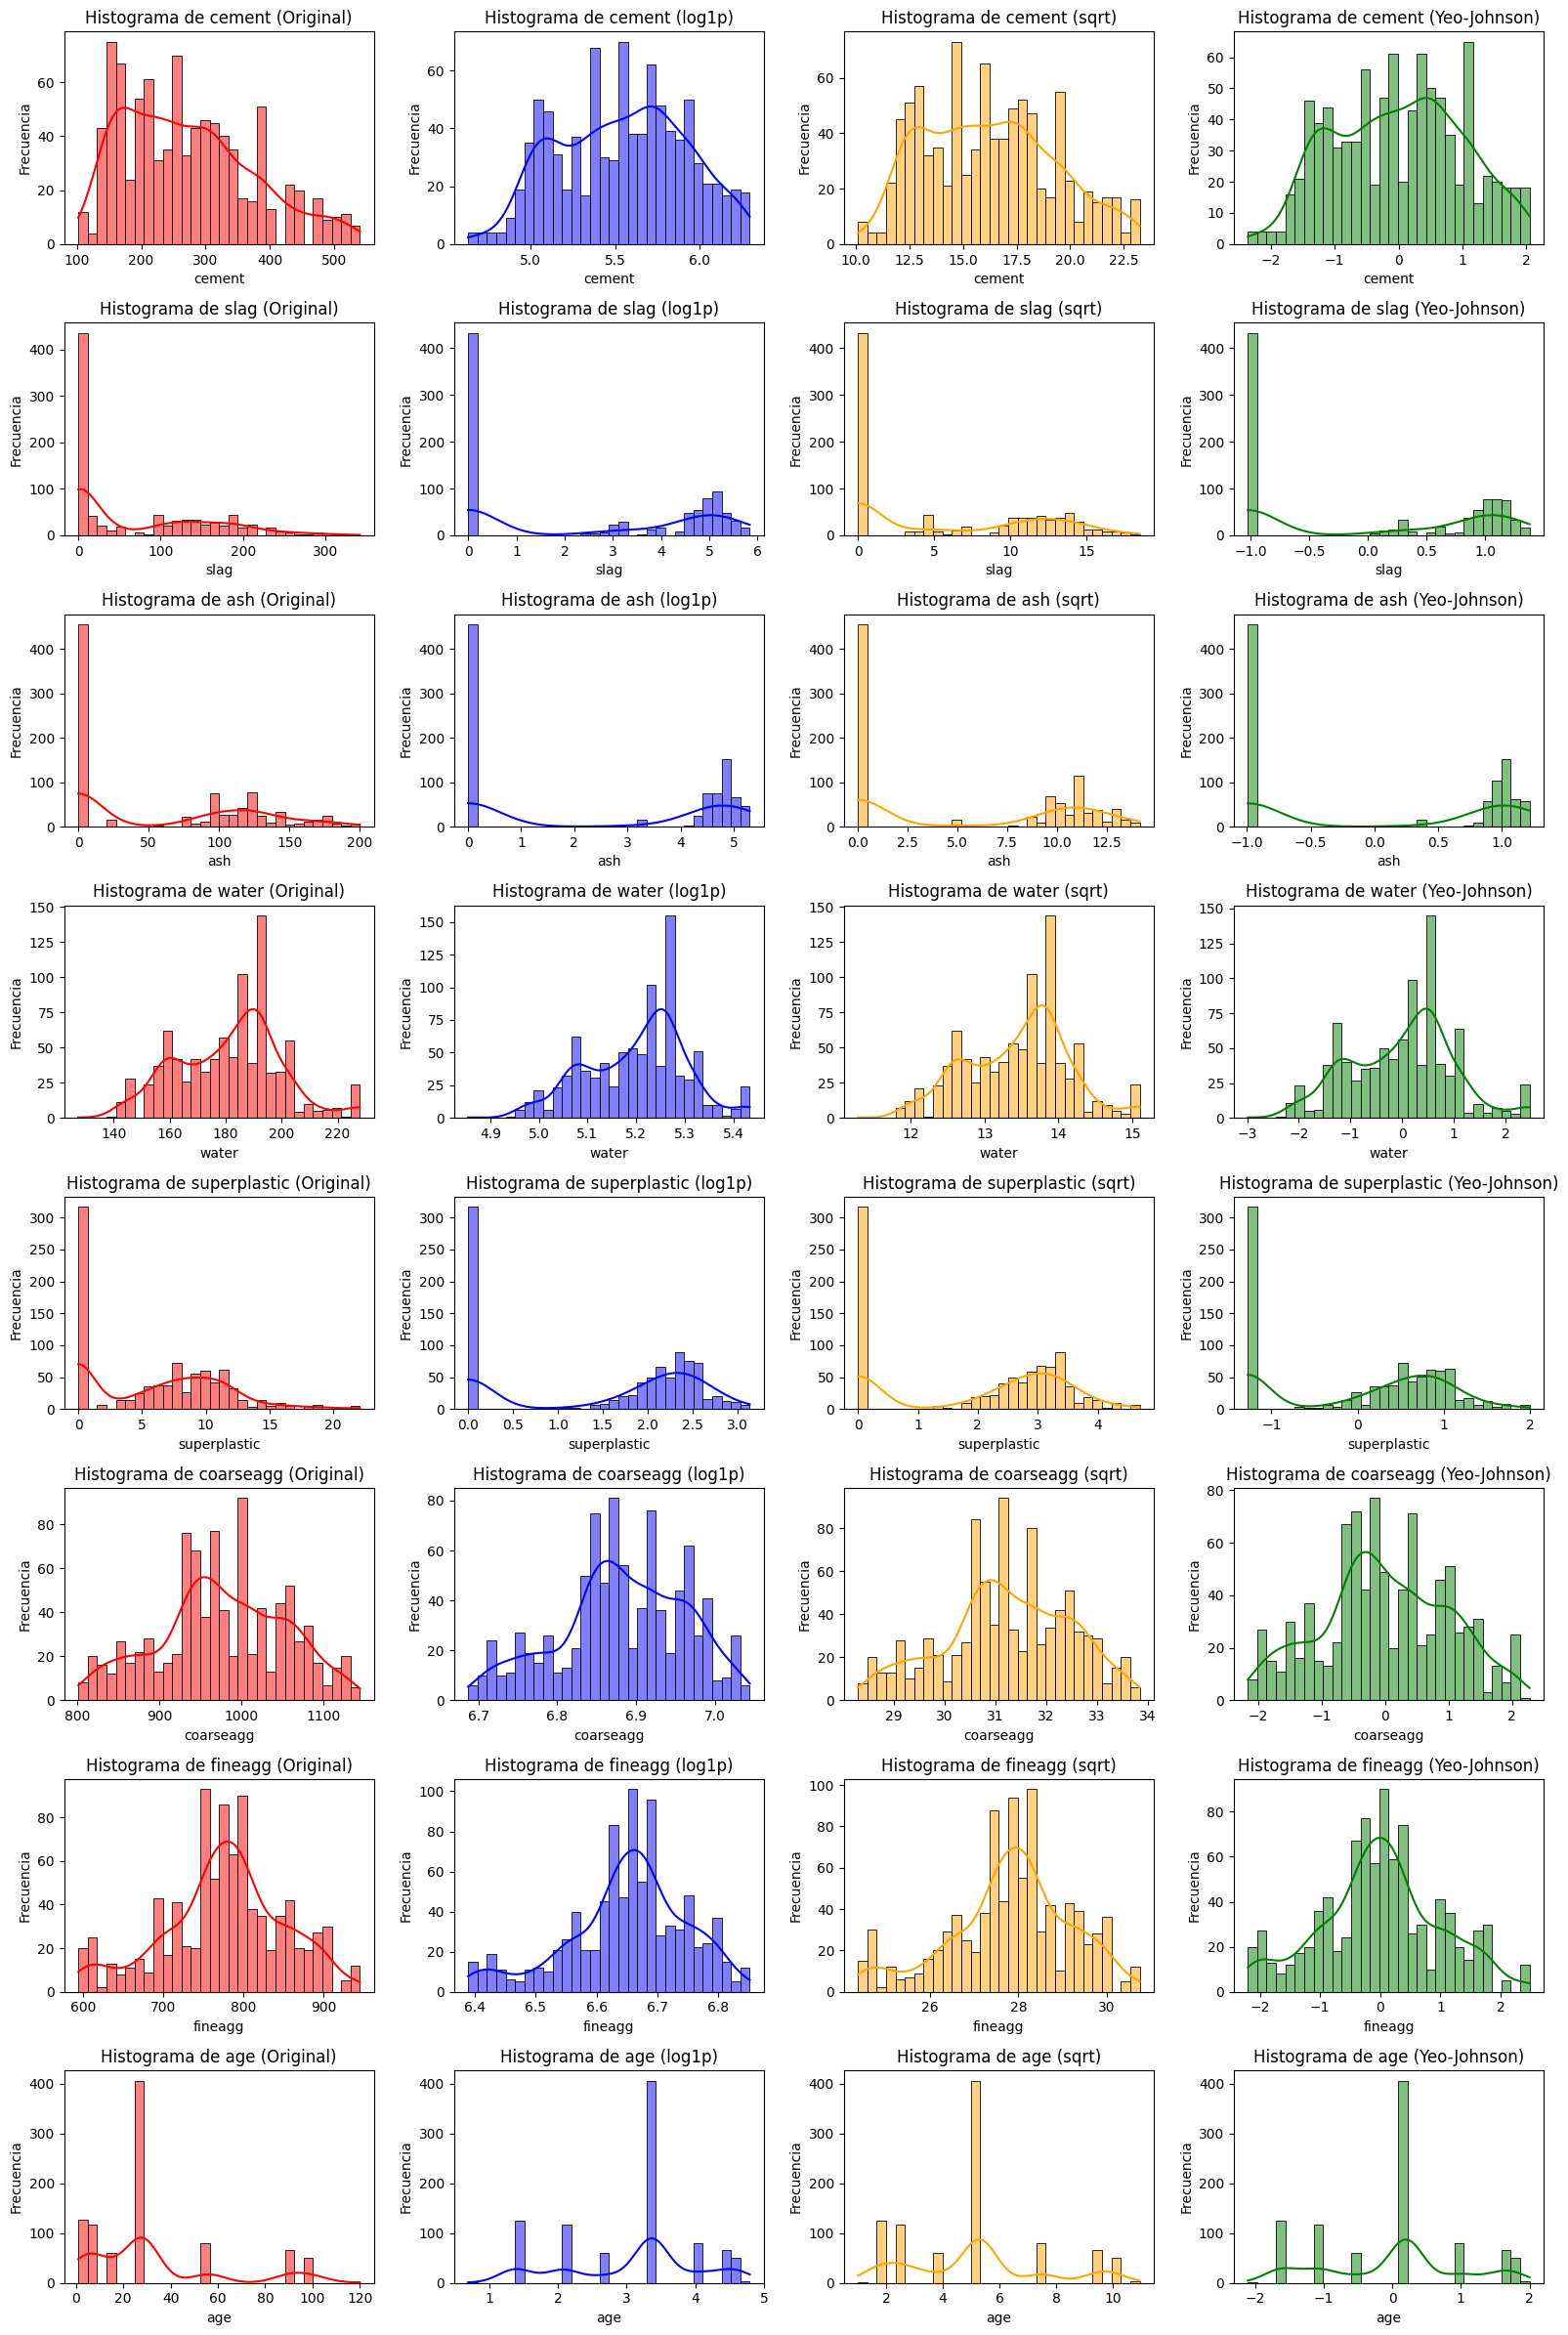

In [12]:
#Definición de características.
X = df.drop(columns='strength')

#Aplicación de transformaciones.
X_log = np.log1p(X)
X_sqrt = np.sqrt(X)
pt = PowerTransformer(method='yeo-johnson')
X_yeojohnson = pt.fit_transform(X)
X_yeojohnson = pd.DataFrame(X_yeojohnson, columns=X.columns, index=X.index)

#Creación y diseño de histogramas.
plt.figure(figsize=(16, 24))
for i, columna in enumerate(X, 1):

  #Histograma de datos originales.
  plt.subplot(8, 4, 4*(i-1) + 1)
  sns.histplot(X[columna], kde=True, bins=30, color='red')
  plt.title(f"Histograma de {columna} (Original)")
  plt.xlabel(columna)
  plt.ylabel("Frecuencia")

  #Histograma de transformación logarítmica.
  plt.subplot(8, 4, 4*(i-1) + 2)
  sns.histplot(X_log[columna], kde=True, bins=30, color='blue')
  plt.title(f"Histograma de {columna} (log1p)")
  plt.xlabel(columna)
  plt.ylabel("Frecuencia")

  #Histograma de transformación raíz cuadrada.
  plt.subplot(8, 4, 4*(i-1) + 3)
  sns.histplot(X_sqrt[columna], kde=True, bins=30, color='orange')
  plt.title(f"Histograma de {columna} (sqrt)")
  plt.xlabel(columna)
  plt.ylabel("Frecuencia")

  #Histograma de transformación Yeo-Johnson.
  plt.subplot(8, 4, 4*(i-1) + 4)
  sns.histplot(X_yeojohnson[columna], kde=True, bins=30, color='green')
  plt.title(f"Histograma de {columna} (Yeo-Johnson)")
  plt.xlabel(columna)
  plt.ylabel("Frecuencia")

#Impresión de histogramas.
plt.tight_layout()
plt.show()

Se aplicó tranformación logarítmica, raíz cuadrada y Yeo-Johnson. Para la primera transformación se debe tener cuidado con los valores que son 0, por lo que la biblioteca de NumPy proporciona una función alternativa que suma 1 a los datos para evitar errores al intentar calcular log(0). Está transformación dio buenos resultados en superplastic y age.

La segunda transformación, que corresponde a raíz cuadrada, obtuvo buenos resultados para cement, slag y superplastic.

La transformación de Yeo-Johnson tiene buenos resultados en cement, superplastic y age. Está última destaca más que el resto de transformaciones, debido a que tiene un mejor manejo de los outliers y puede trabajar con ceros. Además, logró una mejora en las distribuciones de las variables que tienen una alta correlación con strength, por lo que se escogió como transformación base para el modelado.

## - Modelado Predictivo


### - Modelo elegido y parámetros, Entrenamiento y Evaluación


Dado que el análisis de datos tiene como objetivo intentar predecir la resistencia a la compresión del concreto, estamos ante un problema continuo, por lo que se opta por un modelo de regresión lineal.

Los siguientes bloques de código presentan el entrenamiento de los diferentes modelos de regresión, así como la evaluación de sus métricas tanto para la versión original como la versión preprocesada. Para regresión lasso y ridge se usó alpha=0.1 y 1.0 respectivamente, ya que son los valores estándar que se prporcionan en un laboratorio de la clase, sin embargo, estos pueden ser ajustados según convengan.

In [13]:
#Recarga de conjunto de datos.
df_original = pd.read_csv('drive/MyDrive/ClassFiles/concrete.csv')

#Definición de características y objetivo.
X_original = df_original.drop(columns='strength')
y_original = df_original['strength']

#Selección de modelos.
regresion_lineal = LinearRegression()
regresion_lasso = Lasso(alpha=0.1)
regresion_ridge = Ridge(alpha=1.0)

#Definición de validación cruzada.
cv = KFold(n_splits=5, shuffle=True, random_state=42)

#Entrenamiento de modelos.
y_lineal_original = cross_val_predict(regresion_lineal, X_original, y_original, cv=cv)
y_lasso_original = cross_val_predict(regresion_lasso, X_original, y_original, cv=cv)
y_ridge_original = cross_val_predict(regresion_ridge, X_original, y_original, cv=cv)

#Evaluación de regresión lineal.
mse_lineal_original = mean_squared_error(y_original, y_lineal_original)
rmse_lineal_original = np.sqrt(mse_lineal_original)
r2_lineal_original = r2_score(y_original, y_lineal_original)

#Evaluación de regresión lasso.
mse_lasso_original = mean_squared_error(y_original, y_lasso_original)
rmse_lasso_original = np.sqrt(mse_lasso_original)
r2_lasso_original = r2_score(y_original, y_lasso_original)

#Evaluación de regresión ridge.
mse_ridge_original = mean_squared_error(y_original, y_ridge_original)
rmse_ridge_original = np.sqrt(mse_ridge_original)
r2_ridge_original = r2_score(y_original, y_ridge_original)

#Impresión de resultados.
print(f"Error cuadrático medio (MSE):")
print(f"Regresión lineal: {mse_lineal_original:.4f}")
print(f"Regresión lasso: {mse_lasso_original:.4f}")
print(f"Regresión ridge: {mse_ridge_original:.4f}")
print(f"\nRaíz del error cuadrático medio (RMSE):")
print(f"Regresión lineal: {rmse_lineal_original:.4f}")
print(f"Regresión lasso: {rmse_lasso_original:.4f}")
print(f"Regresión ridge: {rmse_ridge_original:.4f}")
print(f"\nCoeficiente de determinación (R²):")
print(f"Regresión lineal: {r2_lineal_original:.4f}")
print(f"Regresión lasso: {r2_lasso_original:.4f}")
print(f"Regresión ridge: {r2_ridge_original:.4f}")

Error cuadrático medio (MSE):
Regresión lineal: 108.7678
Regresión lasso: 108.7667
Regresión ridge: 108.7677

Raíz del error cuadrático medio (RMSE):
Regresión lineal: 10.4292
Regresión lasso: 10.4291
Regresión ridge: 10.4292

Coeficiente de determinación (R²):
Regresión lineal: 0.6099
Regresión lasso: 0.6099
Regresión ridge: 0.6099


Para este caso, al evaluar los modelos en la versión original se obtienen métricas casi idénticas. Enfatizando en el RMSE, con un valor de 10.42 en general, los modelos nos dicen que las predicciones están a 10.42 MPa de los valores reales; por otro lado, el $R^2$ nos dice que los modelos explican casi un 61% de la variabilidad de los datos, lo cual dejan un buen margen de mejora para los modelos.

In [14]:
#Definición de objetivo.
y = df['strength']

#Entrenamiento de modelos.
y_lineal = cross_val_predict(regresion_lineal, X_yeojohnson, y, cv=cv)
y_lasso = cross_val_predict(regresion_lasso, X_yeojohnson, y, cv=cv)
y_ridge = cross_val_predict(regresion_ridge, X_yeojohnson, y, cv=cv)

#Evaluación de regresión lineal.
mse_lineal = mean_squared_error(y, y_lineal)
rmse_lineal = np.sqrt(mse_lineal)
r2_lineal = r2_score(y, y_lineal)

#Evaluación de regresión lasso.
mse_lasso = mean_squared_error(y, y_lasso)
rmse_lasso = np.sqrt(mse_lasso)
r2_lasso = r2_score(y, y_lasso)

#Evaluación de regresión ridge.
mse_ridge = mean_squared_error(y, y_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y, y_ridge)

#Impresión de resultados.
print(f"Error cuadrático medio (MSE):")
print(f"Regresión lineal: {mse_lineal:.4f}")
print(f"Regresión lasso: {mse_lasso:.4f}")
print(f"Regresión ridge: {mse_ridge:.4f}")
print(f"\nRaíz del error cuadrático medio (RMSE):")
print(f"Regresión lineal: {rmse_lineal:.4f}")
print(f"Regresión lasso: {rmse_lasso:.4f}")
print(f"Regresión ridge: {rmse_ridge:.4f}")
print(f"\nCoeficiente de determinación (R²):")
print(f"Regresión lineal: {r2_lineal:.4f}")
print(f"Regresión lasso: {r2_lasso:.4f}")
print(f"Regresión ridge: {r2_ridge:.4f}")

Error cuadrático medio (MSE):
Regresión lineal: 43.5154
Regresión lasso: 43.6315
Regresión ridge: 43.5127

Raíz del error cuadrático medio (RMSE):
Regresión lineal: 6.5966
Regresión lasso: 6.6054
Regresión ridge: 6.5964

Coeficiente de determinación (R²):
Regresión lineal: 0.8266
Regresión lasso: 0.8262
Regresión ridge: 0.8267


Para este caso, al evaluar los modelos con la versión preprocesada se obtienen métricas casi idénticas. Enfatizando en el RMSE, con un valor de 7.35 en general, los modelos nos dicen que las predicciones están a 7.35 MPa de los valores reales; por otro lado, el $R^2$ nos dice que los modelos explican casi un 80% de la variabilidad de los datos.

Es importante destacar la mejora que se ha obtenido de la versión original a la versión preprocesada, con una reducción de 3 unidades del RMSE y un aumento del 19% para el $R^2$. Recordemos que la versión preprocesada solo eliminó los registros duplicados y aplicó transformación Yeo-Johnson.

## - Resultados


Los siguientes bloques de código muestran los resultados obtenidos de manera visual.

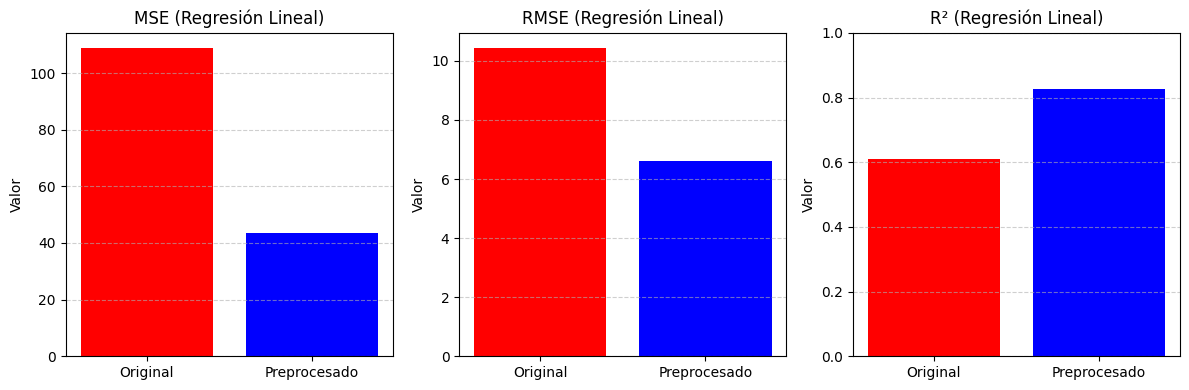

In [15]:
#Creación y diseño de gráficas de barras.
plt.figure(figsize=(12, 4))

#Gráfica de barras de MSE.
plt.subplot(1, 3, 1)
plt.bar(['Original', 'Preprocesado'], [mse_lineal_original, mse_lineal], color=['red', 'blue'])
plt.title('MSE (Regresión Lineal)')
plt.ylabel('Valor')
plt.grid(axis='y', linestyle='--', alpha=0.6)

#Gráfica de barras de RMSE.
plt.subplot(1, 3, 2)
plt.bar(['Original', 'Preprocesado'], [rmse_lineal_original, rmse_lineal], color=['red', 'blue'])
plt.title('RMSE (Regresión Lineal)')
plt.ylabel('Valor')
plt.grid(axis='y', linestyle='--', alpha=0.6)

#Gráfica de barras de R².
plt.subplot(1, 3, 3)
plt.bar(['Original', 'Preprocesado'], [r2_lineal_original, r2_lineal], color=['red', 'blue'])
plt.title('R² (Regresión Lineal)')
plt.ylabel('Valor')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)

#Impresión de gráficas de barras.
plt.tight_layout()
plt.show()

Para las gráficas de barras y de ahora en adelante, se consideró solo el modelo de regresión lineal para ambas versones, esto debido a que los 3 modelos empleados arrojaron métricas muy idénticas. Notesé la mejora de los resultados que hubo desde la versión original hasta la versión preprocesada.

Los siguientes scatterplots muestran los residuos contra las predicciones.

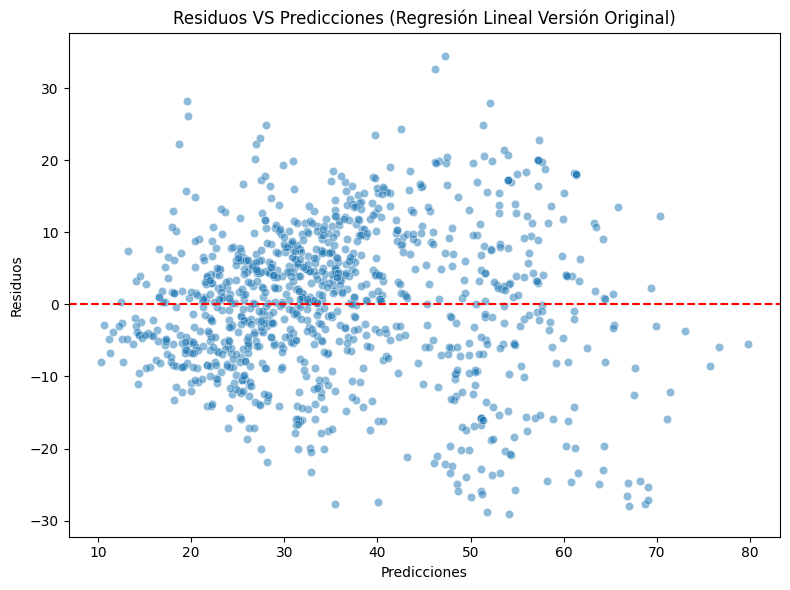

In [16]:
#Cálculo de residuos.
residuos_lineal_original = y_original - y_lineal_original

#Creación y diseño de gráfico de dispersión.
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_lineal_original, y=residuos_lineal_original, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Residuos VS Predicciones (Regresión Lineal Versión Original)")

#Impresión de gráfico de dispersión.
plt.tight_layout()
plt.show()

Los residuos no muestran patrónes destacables y se distribuyen aleatoriamente alrededor de la línea auxiliar (línea roja).

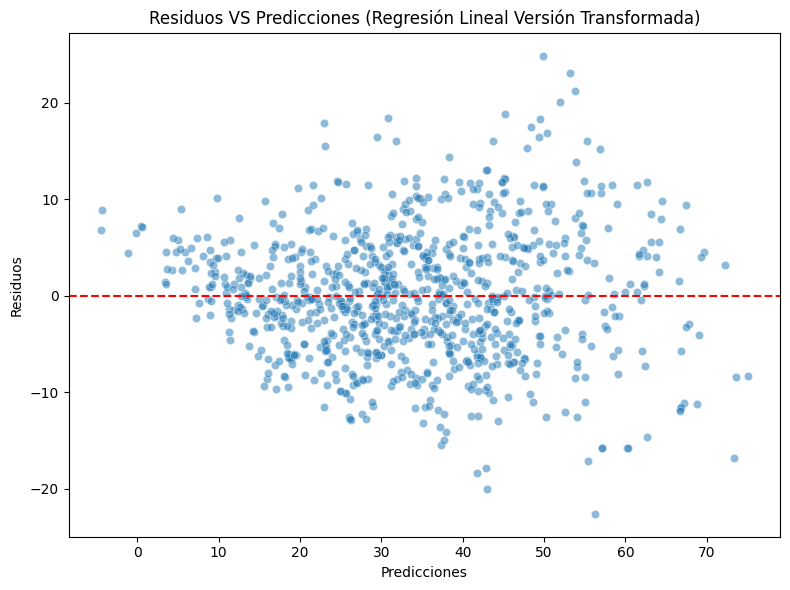

In [17]:
#Cálculo de residuos.
residuos_lineal = y - y_lineal

#Creación y diseño de gráfico de dispersión.
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_lineal, y=residuos_lineal, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Residuos VS Predicciones (Regresión Lineal Versión Transformada)")

#Impresión de gráfico de dispersión.
plt.tight_layout()
plt.show()

Los residuos no muestran patrónes destacables y se distribuyen aleatoriamente alrededor de la línea auxiliar (línea roja).

Los siguientes QQ plots tienen la intención de verificar si los residuos siguen una distribución normal o no para ambas versiones. Así mismo, se incluye una prueba estadística para evaluar la normalidad.

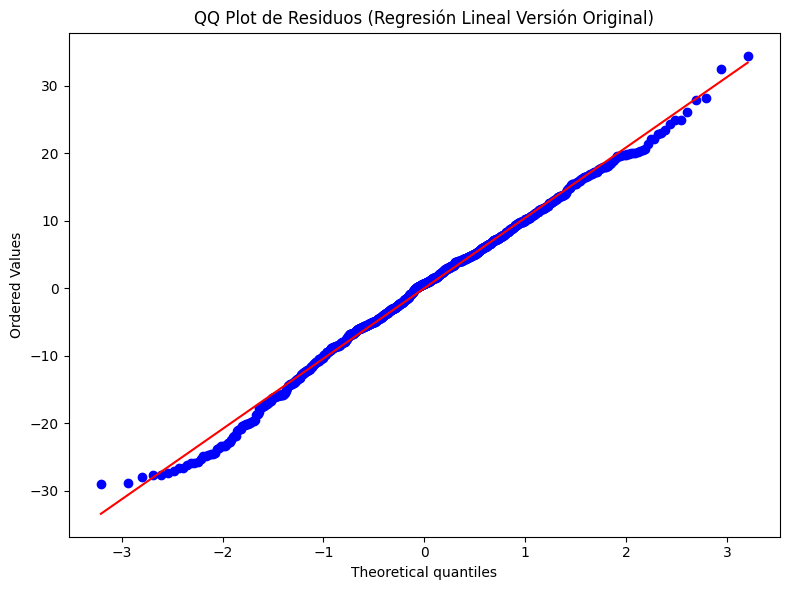

Estadístico de Anderson-Darling: 1.1762996428865335
Nivel de significancia 15.0%: valor crítico = 0.5740
Nivel de significancia 10.0%: valor crítico = 0.6530
Nivel de significancia 5.0%: valor crítico = 0.7840
Nivel de significancia 2.5%: valor crítico = 0.9140
Nivel de significancia 1.0%: valor crítico = 1.0880
❌ Se rechaza la normalidad (a un nivel del 5%)


In [18]:
#Creación y diseño de QQ plot.
plt.figure(figsize=(8, 6))
stats.probplot(residuos_lineal_original, dist='norm', plot=plt)
plt.title("QQ Plot de Residuos (Regresión Lineal Versión Original)")

#Impresión de QQ plot.
plt.tight_layout()
plt.show()

# Aplica la prueba a los residuos
resultado = stats.anderson(residuos_lineal_original, dist='norm')

# Imprime el estadístico
print("Estadístico de Anderson-Darling:", resultado.statistic)

# Imprime los valores críticos por nivel de significancia
for nivel, valor_critico in zip(resultado.significance_level, resultado.critical_values):
    print(f"Nivel de significancia {nivel}%: valor crítico = {valor_critico:.4f}")

# Interpretación básica a 5% (posición 2 en los resultados)
if resultado.statistic < resultado.critical_values[2]:
    print("✅ No se rechaza la normalidad (a un nivel del 5%)")
else:
    print("❌ Se rechaza la normalidad (a un nivel del 5%)")

El QQ plot parece seguir la línea de distribución normal teórica, lo que podría indicar que los residuos si pueden seguir una distribución normal. Hay una ligera desviación en los extremos, lo que podría indicar la presencia de los outliers. Sin embargo, la prueba de normalidad rechaza hipótesis de normalidad.

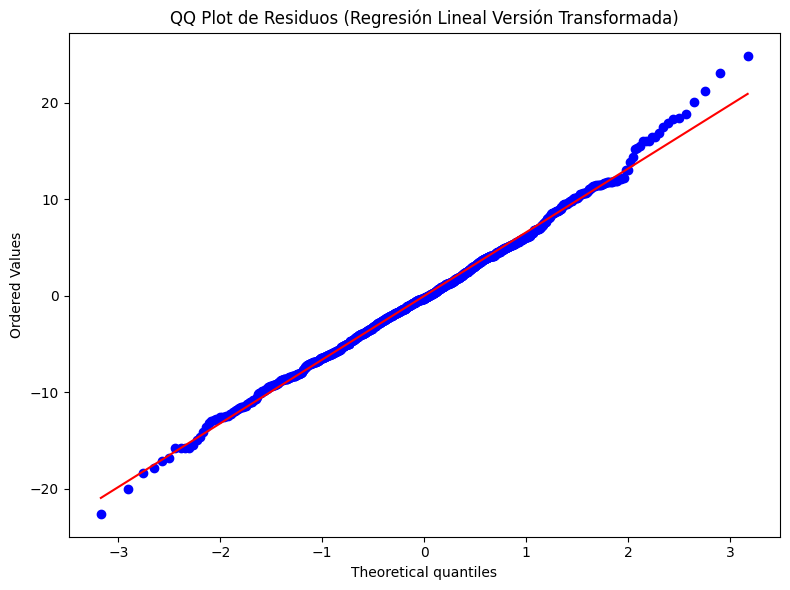

Estadístico de Anderson-Darling: 0.6837682373189864
Nivel de significancia 15.0%: valor crítico = 0.5730
Nivel de significancia 10.0%: valor crítico = 0.6530
Nivel de significancia 5.0%: valor crítico = 0.7840
Nivel de significancia 2.5%: valor crítico = 0.9140
Nivel de significancia 1.0%: valor crítico = 1.0870
✅ No se rechaza la normalidad (a un nivel del 5%)


In [19]:
#Creación y diseño de QQ plot.
plt.figure(figsize=(8, 6))
stats.probplot(residuos_lineal, dist='norm', plot=plt)
plt.title("QQ Plot de Residuos (Regresión Lineal Versión Transformada)")

#Impresión de QQ plot.
plt.tight_layout()
plt.show()

# Aplica la prueba a los residuos
resultado = stats.anderson(residuos_lineal, dist='norm')

# Imprime el estadístico
print("Estadístico de Anderson-Darling:", resultado.statistic)

# Imprime los valores críticos por nivel de significancia
for nivel, valor_critico in zip(resultado.significance_level, resultado.critical_values):
    print(f"Nivel de significancia {nivel}%: valor crítico = {valor_critico:.4f}")

# Interpretación básica a 5% (posición 2 en los resultados)
if resultado.statistic < resultado.critical_values[2]:
    print("✅ No se rechaza la normalidad (a un nivel del 5%)")
else:
    print("❌ Se rechaza la normalidad (a un nivel del 5%)")

El QQ plot parece seguir la línea de distribución normal teórica, lo que podría indicar que los residuos si pueden seguir una distribución normal. Hay una ligera desviación en los extremos, lo que podría indicar la presencia de los outliers. Sin embargo, la prueba de normalidad rechaza hipótesis de normalidad.

# **7. Conclusiones y Trabajos Futuros**

## - Resumen del trabajo realizado, hallazgos y posibles mejoras

Los modelos mostraron un mejor desempeño con un conjunto de datos preprocesado que la versión original, por lo que siempre es bueno aplicar una limpieza para los datos tratando de no alterar tanto la información original.

Recordemos que para este análisis los outliers fueron considerados dentro del modelado, por lo que sería interesante ver el comportamiento que tendría el modelo sin la presencia de tales outliers.

Posibles mejoras implican aplicar técnicas más sofisticadas y robustas a modelos como la regresión lasso y la regresión ridge, aplicando algún algoritmo de optimización de hiperparámetros, como lo es el caso de GridSearch. Sin embargo, este último puede ser computacionalmente costoso dependiendo del rango asignado para probar y encontrar el mejor alpha.

En conclusión, considero que el modelo tiene un desempeño bastante aceptable, pero siempre viene bien la opinión de un experto para seguir mejorando.